## Setup

In [1]:
%%javascript
MathJax.Hub.Config({
      TeX: { equationNumbers: { autoNumber: "AMS" } }
    });MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

In [2]:
from math import exp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Introduction

This notebook will demonstrate how to use the code in the `nnpde1.py` module. The module allows the user to solve an arbitrary 1st-order partial differential equation (PDE) initial value problem (IVP) with two variables, and Dirichlet initial conditions, using a single-hidden layer neural network.

This work is based on the paper ["Artificial Neural Networks for Solving Ordinary and Partial Differential Equations", by Lagaris et al, *IEEE Transactions on Neural Networks, Volume 9, No. 5*, September 1998](http://ieeexplore.ieee.org/document/712178/). Note that the notation used in this notebook and the associated Python code differs slightly from that used in the Lagaris paper.

## The algorithm

Consider an $m$-dimensional space containing vectors $\vec x = (x_1,x_2,...,x_m)$. Any 1st-order PDE for the scalar function $\psi(\vec x)$ can be written in the form:

\begin{equation}
G(\vec x,\psi,\vec \nabla \psi) = 0
\end{equation}

The problem is to find a suitable solution to the PDE using a neural network.

The network is trained using a set of $n$ training points $\vec x_i$ ($1 \leq i \leq n$). This work assumes that the vectors $\vec x_i$ have been scaled so that each component $x_{ij} \in [0,1]$, $1 \leq j \leq m$. The training points need not be evenly-spaced. Note that only the independent variable vectors $\vec x_i$  of the training points are needed - the estimated value of the solution at the training points is obtained using a trial solution $\psi_t$ of the form:

\begin{equation}
\psi_t(\vec x_i,\vec p) = A(\vec x_i) + P(\vec x_i) N(\vec x_i,\vec p)
\end{equation}

or:

\begin{equation}
\psi_{ti} = A_i + P_i N_i
\end{equation}

where $\psi_{ti}$ is the value of the trial solution at the current training point $\vec x_i$, $A_i$ is a function which yields the initial conditions at the origin of each dimension, $P_i$ is a function which vanishes at the origin of each dimension, and $N_i$ is the floating-point single-valued output from an unspecified neural network with network parameters $\vec p$. Note that this trial solution satisfies the boundary conditions by construction - at any boundary, the second term vanishes, leaving $\psi_t(\vec x_i, \vec p_i)=A(\vec x_i)$, which is just the specified boundary condition on that boundary. The PDE is assumed to have been preprocessed so that the boundary conditions lie at the origin. For a 2-variable PDE with independent variables $x$ and $y$, this condition is represented by:

\begin{equation}
\psi_t(0,y,\vec p) = f_0(y)
\end{equation}

\begin{equation}
\psi_t(x,0,\vec p) = g_0(x)
\end{equation}

The analytical forms of $A(\vec x_i)$ and $P(\vec x_i)$ are constructed to meet these requirements, and noting that, by continuity at the origin, $f_0(0)=g_0(0)$. For a 2-variable PDE, we have:

\begin{equation}
A(x,y) = (1-x)f_0(y) + (1-y)(g_0(x) - (1-x)g_0(0))
\end{equation}

\begin{equation}
P(x,y) = xy
\end{equation}

These functions rapidly become more complex as the number of problem dimensions is increased, so this example will utilize a 2-variable PDE. Training is done in a set of *epochs*. A training epoch consists of presenting the neural network with each of the $n$ training points $\vec x_i$, one at a time. For each input point $\vec x_i$, the network output $N_i$ is computed. Once all $n$ points have been presented, the epoch is complete, and the error function $E$ is computed. The problem definition provides an analytical form for the error function, as the sum of squared errors (SSE) for each of the training points:

\begin{equation}
E = \sum_{i=1}^{n} \left( G(\vec x_i,\psi_{ti}, \vec \nabla \psi_{ti}) \right)^2 =
\sum_{i=1}^{n} G_i^2
\end{equation}

Once this error function is computed, the parameters in the neural network are adjusted to reduce the error. Eventually, a minimum of $E$ is attained, and the resulting final form of $\psi_t(x)$ is used as the solution to the original PDE.

## Computing the network output $N_i$

The neural network used in this work has a simple structure. One input node for each component of $\vec x_i$ is used (for a total of $m$ input nodes) to provide the training data. Each input node is fully-connected to each of a set of $H$ hidden nodes, each using a sigmoid transfer function. Each hidden node is connected to the single output node, which uses a linear transfer function with a weight for the signal from each hidden node.

During each step of a training epoch, the input to the network is just the training point $\vec x_i$. Each input node $j$ receives one component $x_{ij}$, and emits that value as output. These outputs are sent to each of the $H$ hidden nodes. At each hidden node $k$, the input values $x_{ij}$ are combined and scaled by the equation:

\begin{equation}
z_{ik} = \sum_{j=1}^m w_{jk} x_{ij} + u_k
\end{equation}

where  $w_{jk}$ is the weight for input node $j$ at hidden node $k$, and $u_k$ is the bias at hidden node $k$. This combined value is then used as the input to a sigmoidal transfer function:

\begin{equation}
\sigma_{ik} = \sigma(z_{ik})
\end{equation}

where:

\begin{equation}
\sigma(z) = \frac {1}{1+e^{-z}}
\end{equation}

A plot of this transfer function and its first three derivatives is provided below.

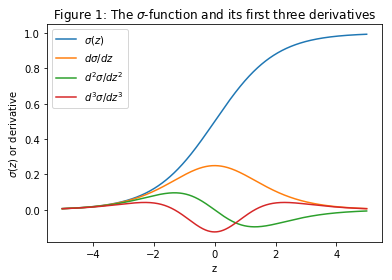

In [3]:
def sigma(z):
    return 1 / (1 + exp(-z))

def dsigma_dz(z):
    return exp(-z) / (1 + exp(-z))**2

def d2sigma_dz2(z):
    return (
        2 * exp(-2 * z) / (1 + exp(-z))**3 - exp(-z) / (1 + exp(-z))**2
    )

def d3sigma_dz3(z):
    return (
        6 * exp(-3 * z) / (1 + exp(-z))**4
        - 6 * exp(-2 * z) / (1 + exp(-z))**3
        + exp(-z) / (1 + exp(-z))**2
    )

z = np.arange(-5, 5, 0.01)
n = len(z)
s = np.zeros(n)
ds_dz = np.zeros(n)
d2s_dz2 = np.zeros(n)
d3s_dz3 = np.zeros(n)
for i in range(n):
    s[i] = sigma(z[i])
    ds_dz[i] = dsigma_dz(z[i])
    d2s_dz2[i] = d2sigma_dz2(z[i])
    d3s_dz3[i] = d3sigma_dz3(z[i])
plt.plot(z,s,label = "$\sigma(z)$")
plt.plot(z,ds_dz,label = "$d\sigma/dz$")
plt.plot(z,d2s_dz2, label = "$d^2\sigma/dz^2$")
plt.plot(z,d3s_dz3, label = "$d^3\sigma/dz^3$");
plt.xlabel("z")
plt.ylabel("$\sigma(z)$ or derivative")
plt.title("Figure 1: The $\sigma$-function and its first three derivatives")
plt.legend();

Once the $\sigma_{ik}$ are computed, they are all passed to the single output node, where they are processed by a linear transfer function to create the network output for the current input point $\vec x_i$:

\begin{equation}
N_i = \sum_{k=1}^{H}v_k\sigma_{ik}
\end{equation}

where $v_k$ is the weight applied to the output from hidden node $k$ at the output node. Once $N_i$ has been computed, the trial function $\psi_{ti}$ is computed. To compute the value of $G_i$ (and thus $E$), we also need the gradient of the trial function $\vec \nabla \psi_{ti}$.

\begin{equation}
\vec \nabla \psi_{ti} = \vec \nabla (A_i + P_i N_i)
\end{equation}

Each component $j$ of this gradient may be written as:

\begin{equation}
\frac {\partial \psi_{ti}}{\partial x_{ij}} =
\frac {\partial A_i}{\partial x_{ij}} + P_i \frac {\partial N_i}{\partial x_{ij}} + \frac {\partial P_i}{\partial x_{ij}} N_i
\end{equation}

The functional forms of the derivatives of $A_i$ and $P_i$ with respect to $x_{ij}$ are computed $\it a \ priori$ from their known analytical forms, which may vary based on the problem under investigation. The values of the network output derivatives $\frac {\partial N_i}{\partial x_{ij}}$ are computed analytically using the known form of the network and its weights and biases.

\begin{equation}
\frac {\partial N_i}{\partial x_{ij}} =
\frac {\partial}{\partial x_{ij}} \sum_{k=1}^{H} v_k \sigma_{ik} =
\sum_{k=1}^{H} v_k \frac {\partial \sigma_{ik}}{\partial x_{ij}} =
\sum_{k=1}^{H} v_k \frac {\partial \sigma_{ik}}{\partial z_{ik}} \frac {\partial z_{ik}}{\partial x_{ij}} = \sum_{k=1}^{H} v_k \sigma_{ik}^{(1)} w_{jk}
\end{equation}

where the derivatives of $\sigma$ are given by:

\begin{equation}
\sigma^{(k)} = \frac {d^k \sigma}{dz^k}
\end{equation}

With the values of $\psi_{ti}$ and $\vec \nabla \psi_{ti}$, we can now compute the values of $G_i$, and then the error function $E$ for the current epoch.

## Updating the network parameters

The network parameters are the weights and biases of the hidden and output nodes. For an $m$-dimensional input point $\vec x_i$, and a set of $H$ hidden nodes, we have a total of $N_p = (m+2)H$ parameters in total: a weight for each $x_{ij}$ for each hidden node, a bias for each hidden node, and an output weight for each hidden node.

Since the objective function to minimize is the error $E$, the value of each network parameter $p$ (where $p$ represents $v_k$, $u_k$, or $w_{jk}$) is updated using a scaled Newton's method:

\begin{equation}
p_{new}=p - \eta \frac {\frac {\partial E}{\partial p}} {\frac {\partial^2 E}{\partial p^2}}
\end{equation}

where $\eta$ is the *learning rate* (usually $\eta < 1$). The learning rate is used to reduce the chance of solution instability due to large values of the correction factor in Newton's method. The derivatives of $E$ are computed using the known form of $G_i$, the network, and the network parameters.

This process of parameter updates is repeated until the specified maximum number of training epochs has been applied. Note that the same set of training points is presented during each epoch.

## Computing the derivatives of $E$

The partial derivatives of $E$ with respect to any network parameter $p$ are given by:

\begin{equation}
\frac {\partial E}{\partial p} =
2 \sum_{i=1}^n G_i \frac {\partial G_i}{\partial p}
\end{equation}

\begin{equation}
\frac {\partial^2 E}{\partial p^2} =
2 \sum_{i=1}^n \left[G_i \frac {\partial^2 G_i}{\partial p^2} + \left(\frac {\partial G_i}{\partial p} \right)^2 \right]
\end{equation}

## Computing the derivatives of $G_i$

The partial derivatives of $G_i$ with respect to $x_{ij}$, $\psi_{ti}$, and $\frac {\partial \psi_{ti}} {\partial x_{ij}}$ are determined $\it a\ priori$ from the analytical form of $G$. Note also that $\frac {\partial x_{ij}} {\partial p_{hk}} = 0$. The remaining partial derivatives of $G_i$ are:

\begin{equation}
\frac {\partial G_i}{\partial p} =
\frac {\partial G_i}{\partial \psi_{ti}} \frac {\partial \psi_{ti}}{\partial p} +
\sum_{j=1}^m \frac {\partial G_i}{\partial \left(\frac {\partial \psi_{ti}}{\partial x_{ij}}\right)}
\frac {\partial^2 \psi_{ti}}{\partial p \partial x_{ij}}
\end{equation}

\begin{equation}
\frac {\partial^2 G_i}{\partial p^2} =
\frac {\partial G_i}{\partial \psi_{ti}}
\frac {\partial^2 \psi_{ti}}{\partial p^2} +
\frac {\partial} {\partial p} \left ( \frac {\partial G_i} {\partial \psi_{ti}} \right ) \frac {\partial \psi_{ti}} {\partial p} +
\sum_{j=1}^m
\left [
\frac {\partial G_i} {\partial \left ( \frac {\partial \psi_{ti}} {\partial x_{ij}} \right ) }
\frac {\partial \psi_{ti}^3} {\partial p^2 \partial x_{ij}} +
\frac {\partial} {\partial p} \left ( \frac {\partial G_i} {\partial \frac {\partial \psi_{ti}} {\partial x_{ij}}} \right )
\frac {\partial \psi_{ti}^2} {\partial p \partial x_{ij}}
\right ]
\end{equation}

Note that the partials of $G_i$ by $\vec x$, $\psi$, and $\vec \nabla \psi$ must be supplied in anaytical form, since the analytical form of $G_i(\vec x,\psi,\vec \nabla \psi)$ is known. Partials of these partials by parameters $p$ are found using the chain rule, as they are for $G_i$ itself.

## Computing the derivatives of $\psi_{ti}$

 The derivatives of the trial solution $\psi_{t}$ are given by:

\begin{equation}
\frac {\partial \psi_{ti}} {\partial p} = \
P_i \frac {\partial N_i} {\partial p}
\end{equation}

\begin{equation}
\frac {\partial^2 \psi_{ti}} {\partial p^2} = \
P_i \frac {\partial^2 N_i} {\partial p^2}
\end{equation}

\begin{equation}
\frac {\partial^2 \psi_{ti}} {\partial p \partial x_{ij}} = \
P_i \frac {\partial^2 N_i} {\partial p \partial x_{ij}} + \
\frac {\partial P_i} {\partial x_{ij}} \frac {\partial N_i} {\partial p}
\end{equation}

\begin{equation}
\frac {\partial^3 \psi_{ti}} {\partial p^2 \partial x_{ij}} = \
P_i \frac {\partial^3 N_i} {\partial p^2 \partial x_{ij}} + \
\frac {\partial P_i} {\partial x_{ij}} \frac {\partial^2 N_i} {\partial p^2}
\end{equation}

Note that $A_i$ and $P_i$ are independent of the network parameters $p$.

## Computing the derivatives of $N_i$

The partial derivatives of $N_i$ are:

\begin{equation}
\frac {\partial N_i} {\partial x_{ij}} = \sum_{k=1}^H v_k \sigma_{ik}^{(1)} w_{jk}
\end{equation}

\begin{equation}
\frac {\partial N_i} {\partial p} =
\sum_{k=1}^H \left ( v_k \sigma_{ik}^{(1)} \frac {\partial z_{ik}} {\partial p} +
\frac {\partial v_k} {\partial p} \sigma_{ik} \right )
\end{equation}

\begin{equation}
\frac {\partial^2 N_i}{\partial p^2} =
\sum_{k=1}^H \left(
v_k \sigma_{ik}^{(2)} \left( \frac {\partial z_{ik}}{\partial p} \right)^2 +
2 \frac {\partial v_k}{\partial p} \sigma_{ik}^{(1)} \frac {\partial z_{ik}}{\partial p} 
\right)
\end{equation}

\begin{equation}
\frac {\partial^2 N_i}{\partial p \partial x_{ij}} =
\sum_{k=1}^{H} \left(
v_k \sigma_{ik}^{(1)} \frac {\partial w_{jk}} {\partial p} + \
v_k \sigma_{ik}^{(2)} \frac {\partial z_{ik}} {\partial p} w_{jk} + \
\frac {\partial v_k} {\partial p} \sigma_{ik}^{(1)} w_{jk}
\right)
\end{equation}

\begin{equation}
\frac {\partial^3 N_i}{\partial p^2 \partial x_i} =
\sum_{k=1}^H
\left(
v_k \sigma_{ik}^{(2)} \frac {\partial z_{ik}} {\partial p} \frac {\partial w_{jk}} {\partial p} +
\frac {\partial v_k} {\partial p} \sigma_{ik}^{(1)} \frac {\partial w_{jk}} {\partial p} +
v_k \sigma_{ik}^{(2)} \frac {\partial z_{ik}} {\partial p} \frac {\partial w_{jk}} {\partial p} +
v_k \sigma_{ik}^{(3)} \left( \frac {\partial z_{ik}} {\partial p} \right)^2 w_{jk} +
\frac {\partial v_k} {\partial p} \sigma_{ik}^{(2)} \frac {\partial z_{ik}} {\partial p} w_{jk} +
\frac {\partial v_k} {\partial p} \sigma_{ik}^{(1)} \frac {\partial w_{jk}} {\partial p} +
\frac {\partial v_k} {\partial p} \sigma_{ik}^{(2)} \frac {\partial z_{ik}} {\partial p} w_{jlk}
\right)
\end{equation}

Most of these expressions can now be simplified using the following relations between the network parameters ($*$ means any index or combination of indices):

\begin{equation}
\frac {\partial v_k}{\partial v_l} = \delta_{kl},
\frac {\partial v_k}{\partial w_*} = \frac {\partial v_k}{\partial u_*} = 0
\end{equation}


\begin{equation}
\frac {\partial u_k}{\partial u_l} = \delta_{kl},
\frac {\partial u_k}{\partial v_*} = \frac {\partial u_k}{\partial w_*} = 0
\end{equation}

\begin{equation}
\frac {\partial w_{jk}}{\partial w_{hl}} = \delta_{jh} \delta_{kl},
\frac {\partial w_{jk}}{\partial v_*} = \frac {\partial w_{jk}}{\partial u_*} = 0
\end{equation}

\begin{equation}
\frac {\partial z_{ik}}{\partial v_*} = 0,
\frac {\partial z_{ik}}{\partial w_{jl}} = x_{ij} \delta_{kl},
\frac {\partial z_{ik}}{\partial u_l} = \delta_{kl},
\end{equation}

# Walking through an example problem

Consider the simple 1st-order partial differential equation:

\begin{equation}
G(\vec x, \psi, \vec \nabla \psi) = 2xy - \psi
\end{equation}

In Python form:

In [4]:
def Gf(xy, psi, del_psi):
    (x, y) = xy
    (dpsi_dx, dpsi_dy) = del_psi
    return 2*x*y - psi

The analytical solution to this PDE is:

\begin{equation}
\psi(x,y) = 2xy
\end{equation}

This function is plotted in the following figure:

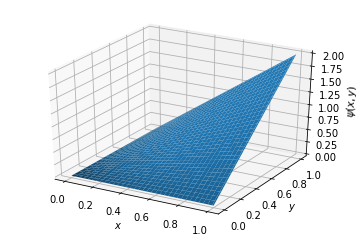

In [5]:
fig = plt.figure()
ax = fig.gca(projection = '3d')
x = np.linspace(0,1,101)
y = np.linspace(0,1,101)
x,y = np.meshgrid(x,y)
psi = 2*x*y
z = psi.reshape(x.shape)
surf = ax.plot_surface(x, y, z)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlim3d(0, 2)
ax.set_zlabel('$\psi(x,y)$');

We need to specify quite a few derivatives, but most of them vanish. To begin, the first partials of $G(\vec x,\psi,\vec \nabla \psi)$:

\begin{equation}
\frac {\partial G} {\partial x} = 2y
\end{equation}

\begin{equation}
\frac {\partial G} {\partial y} = 2x
\end{equation}

In Python form, these equations are (unused arguments are ignored):

In [6]:
def dG_dxf(xy,psi,del_psi):
    (x,y) = xy
    return 2*y

In [7]:
def dG_dyf(xy, psi, del_psi):
    (x, y) = xy
    return 2*x

In [8]:
del_Gf = (dG_dxf,dG_dyf)

\begin{equation}
\frac {\partial G} {\partial \psi} = -1
\end{equation}

In Python form:

In [9]:
def dG_dpsif(xy, psi, del_psi):
    return -1

\begin{equation}
\frac {\partial G} {\partial \left ( \frac {\partial \psi} {\partial x} \right )} = 0
\end{equation}

\begin{equation}
\frac {\partial G} {\partial \left ( \frac {\partial \psi} {\partial y} \right )} = 0
\end{equation}

In Python form:

In [10]:
def dG_dpsi_dxf(xy, psi, del_psi):
    (dpsi_dx, dpsi_dy) = del_psi
    return 0

In [11]:
def dG_dpsi_dyf(xy, psi, del_psi):
    (dpsi_dx, dpsi_dy) = del_psi
    return 0

In [12]:
dG_ddel_psif = (dG_dpsi_dxf,dG_dpsi_dyf)

The required second partials are:

\begin{equation}
\frac {\partial^2 G} {\partial \psi^2} = 0
\end{equation}

In [13]:
def d2G_dpsi2f(xy, psi, del_psi):
    return 0

\begin{equation}
\frac {\partial^2 G} {\partial \left ( \frac {\partial \psi} {\partial x} \right ) \partial \psi} = 0
\end{equation}

\begin{equation}
\frac {\partial^2 G} {\partial \left ( \frac {\partial \psi} {\partial y} \right ) \partial \psi} = 0
\end{equation}

In [14]:
def d2G_ddxdpsif(xy, psi, del_psi):
    return 0

In [15]:
def d2G_ddydpsif(xy, psi, del_psi):
    return 0

In [16]:
d2G_ddel_psi_dpsif = (d2G_ddxdpsif, d2G_ddydpsif)

\begin{equation}
\frac {\partial^2 G} { \partial \psi \partial \left ( \frac {\partial \psi} {\partial x} \right )} = 0
\end{equation}

\begin{equation}
\frac {\partial^2 G} { \partial \psi \partial \left ( \frac {\partial \psi} {\partial y} \right )} = 0
\end{equation}

In [17]:
def d2G_dpsiddx(xy, psi, del_psi):
    return 0

In [18]:
def d2G_dpsiddy(xy, psi, del_psi):
    return 0

In [19]:
d2G_dpsi_ddel_psif = (d2G_dpsiddx, d2G_dpsiddy)

\begin{equation}
\frac {\partial^2 G} { \partial \left ( \frac {\partial \psi} {\partial x} \right )^2} = 0
\end{equation}

\begin{equation}
\frac {\partial^2 G} { \partial \left ( \frac {\partial \psi} {\partial y} \right )^2} = 0
\end{equation}

In [20]:
def d2G_ddx2f(xy, psi, del_psi):
    return 0

In [21]:
def d2G_ddy2f(xy, psi, del_psi):
    return 0

In [22]:
d2G_ddel_psi2f = (d2G_ddx2f, d2G_ddy2f)

The boundary condition functions and their required derivatives are:

\begin{equation}
f_0(y)=0
\end{equation}

\begin{equation}
g_0(x)=0
\end{equation}

In [23]:
def f0f(y):
    return 0

In [24]:
def g0f(x):
    return 0

In [25]:
bcf = (f0f,g0f)

\begin{equation}
\frac {\partial f_0} {\partial y} = 0
\end{equation}

\begin{equation}
\frac {\partial g_0} {\partial x} = 0
\end{equation}

In [26]:
def df0_dyf(y):
    return 0

In [27]:
def dg0_dxf(x):
    return 0

In [28]:
bcdf = (df0_dyf, dg0_dxf)

Now that we have the forms for all of these derivatives and boundary conditions, we can create the training points. Use an evenly-spaced grid of 25 points.

In [29]:
nxy = 5
dxy = 1 / nxy
x = np.zeros((nxy**2, 2))
for j in range(nxy):
    for i in range(nxy):
        k = j * nxy + i
        x[k][0] = i * dxy
        x[k][1] = j * dxy

Call the function which solves the ODE. Use 10 nodes in the hidden layer, and 1000 training epochs, a learning rate of 0.01, and activate verbose output.

In [30]:
from nnpde1 import nnpde1
(psit,del_psi) = nnpde1(
        Gf,             # 2-variable, 1st-order PDE IVP to solve
        bcf,            # BC functions
        bcdf,           # BC function derivatives
        dG_dpsif,       # Partial of G wrt psi
        del_Gf,         # Gradient of G
        dG_ddel_psif,   # Partials of G wrt del psi
        d2G_dpsi2f,     # 2nd partial wrt psi
        d2G_ddel_psi_dpsif, # Cross-partials
        d2G_dpsi_ddel_psif, # Cross-partials
        d2G_ddel_psi2f, # 2nd partial wrt del psi
        x,              # Training points as pairs
        nhid = 10,      # Node count in hidden layer
        maxepochs = 1000, # Max training epochs
        eta = 0.01,     # Learning rate
        debug = False,
        verbose = True
    )

0 7.259678471615555
1 6.248685879117241
2 4.9170379776624555
3 3.875857662079813
4 3.059191476119239
5 2.417321001883486
6 1.9121377884696371
7 1.5141402812294846
8 1.2003514459063573
9 0.9528056886774425
10 0.7574183738824788
11 0.6031265980213558
12 0.4812288779507953
13 0.3848739177836782
14 0.30866274464738
15 0.24833793750677527
16 0.20054026690797222
17 0.16261782652126042
18 0.1324762564802146
19 0.1084612861157902
20 0.08926677199483413
21 0.07386281089113089
22 0.061439485878349874
23 0.05136251809005266
24 0.043137751469951274
25 0.03638214650826349
26 0.03079977856599611
27 0.026162033253718103
28 0.022291580473301063
29 0.019049781779831944
30 0.016327092394225563
31 0.014035924014043508
32 0.01210541739075375
33 0.010477631611797239
34 0.009104752980773881
35 0.007947026254101729
36 0.006971196152055507
37 0.006149311983608672
38 0.005457794471327426
39 0.0048766955026393
40 0.004389102730104373
41 0.003980655056596792
42 0.003639144495124007
43 0.00335418632736971
44 0.00

328 0.0015351903236291143
329 0.001530228906718276
330 0.001525250941372109
331 0.0015202567177375033
332 0.0015152465237323076
333 0.0015102206450463272
334 0.001505179365143472
335 0.0015001229652645447
336 0.0014950517244306293
337 0.0014899659194476873
338 0.0014848658249115756
339 0.001479751713213995
340 0.0014746238545491432
341 0.0014694825169211116
342 0.0014643279661518077
343 0.001459160465890071
344 0.001453980277620813
345 0.0014487876606755603
346 0.0014435828722429856
347 0.001438366167380691
348 0.0014331377990272212
349 0.0014278980180150481
350 0.0014226470730840013
351 0.001417385210895422
352 0.0014121126760470112
353 0.001406829711088088
354 0.0014015365565358845
355 0.0013962334508920526
356 0.0013909206306600948
357 0.001385598330363218
358 0.001380266782563107
359 0.0013749262178789257
360 0.001369576865007373
361 0.0013642189507430914
362 0.001358852699999862
363 0.001353478335832352
364 0.0013480960794587274
365 0.0013427061502834937
366 0.0013373087659216505


644 0.0003515111767652474
645 0.00035073044045164033
646 0.0003499538342453132
647 0.0003491812707952853
648 0.00034841266510718307
649 0.0003476479344815031
650 0.00034688699845354654
651 0.00034612977873463394
652 0.00034537619915485314
653 0.0003446261856071133
654 0.0003438796659926524
655 0.00034313657016782774
656 0.00034239682989220863
657 0.00034166037877800005
658 0.0003409271522407545
659 0.0003401970874511952
660 0.0003394701232883429
661 0.00033874620029388804
662 0.0003380252606275316
663 0.0003373072480236548
664 0.0003365921077489491
665 0.00033587978656123127
666 0.0003351702326692515
667 0.0003344633956935487
668 0.0003337592266284098
669 0.00033305767780456567
670 0.000332358702853193
671 0.00033166225667054185
672 0.0003309682953837358
673 0.0003302767763172576
674 0.00032958765796045305
675 0.0003289008999358349
676 0.0003282164629682387
677 0.0003275343088547619
678 0.000326854400435494
679 0.0003261767015651018
680 0.0003255011770850427
681 0.00032482779279660774


958 0.00018314677427926855
959 0.00018275632954005555
960 0.00018236663118513576
961 0.00018197767816361809
962 0.0001815894694246535
963 0.00018120200391746584
964 0.0001808152805912846
965 0.00018042929839544574
966 0.00018004405627929427
967 0.0001796595531922736
968 0.00017927578808389066
969 0.0001788927599037192
970 0.00017851046760140974
971 0.0001781289101267127
972 0.00017774808642945377
973 0.00017736799545955628
974 0.00017698863616706032
975 0.00017661000750208427
976 0.00017623210841488887
977 0.00017585493785582553
978 0.0001754784947753914
979 0.0001751027781242005
980 0.00017472778685300513
981 0.00017435351991269512
982 0.0001739799762543136
983 0.00017360715482905788
984 0.00017323505458827887
985 0.00017286367448349042
986 0.00017249301346639056
987 0.00017212307048884682
988 0.00017175384450289472
989 0.00017138533446080313
990 0.00017101753931498818
991 0.00017065045801810202
992 0.00017028408952298528
993 0.0001699184327827116
994 0.00016955348675056398
995 0.0001

Compare the computed values with the analytical values.

In [31]:
def psiaf(xy):
    (x, y) = xy
    return 2*x*y

In [32]:
def dpsia_dxf(xy):
    (x, y) = xy
    return 2*y

In [33]:
def dpsia_dyf(xy):
    (x, y) = xy
    return 2*x

In [34]:
del_psiaf = ( dpsia_dxf, dpsia_dyf )

In [35]:
psia = np.zeros(len(x))
for i in range(len(x)):
    psia[i] = psiaf(x[i])

In [36]:
del_psia = np.zeros((len(x), len(x[1])))
for i in range(len(x)):
    for j in range(len(x[0])):
        del_psia[i][j] = del_psiaf[j](x[i])

Compute the RMS error of the computed solution and its partial derivatives.

In [37]:
from math import sqrt
psi_err = psit - psia
rmse_psi = sqrt(sum(psi_err**2) / len(x))

In [38]:
del_psi_err = del_psi - del_psia
rmse_del_psi = np.zeros(len(x[0]))
e2sum = np.zeros(len(x[0]))
for j in range(len(x[0])):
    for i in range(len(x)):
        e2sum[j] += del_psi_err[i][j]**2
    rmse_del_psi[j] = sqrt(e2sum[j] / len(x))

Compare the results.

In [39]:
print('    x        y      psia     psit   dpsia_dx dpsia_dy dpsit_dx dpsit_dy')
for i in range(len(psia)):
    print('%.6f %.6f %.6f %.6f %.6f %.6f %.6f %.6f' %
          (x[i][0], x[i][1],
           psia[i], psit[i],
           del_psia[i][0], del_psi[i][0],
           del_psia[i][1], del_psi[i][1])
        )
print('RMSE      %f          %f     %f' % 
      (rmse_psi, rmse_del_psi[0], rmse_del_psi[1]))

    x        y      psia     psit   dpsia_dx dpsia_dy dpsit_dx dpsit_dy
0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
0.200000 0.000000 0.000000 0.000000 0.000000 0.000000 0.400000 186.405065
0.400000 0.000000 0.000000 0.000000 0.000000 0.000000 0.800000 0.864110
0.600000 0.000000 0.000000 0.000000 0.000000 0.000000 1.200000 1.171520
0.800000 0.000000 0.000000 0.000000 0.000000 0.000000 1.600000 1.573176
0.000000 0.200000 0.000000 0.000000 0.400000 25.957500 0.000000 0.000000
0.200000 0.200000 0.080000 0.078583 0.400000 0.351843 0.400000 0.341459
0.400000 0.200000 0.160000 0.156410 0.400000 0.397257 0.800000 0.789320
0.600000 0.200000 0.240000 0.236312 0.400000 0.401479 1.200000 1.190845
0.800000 0.200000 0.320000 0.316899 0.400000 0.404153 1.600000 1.594858
0.000000 0.400000 0.000000 0.000000 0.800000 0.777689 0.000000 0.000000
0.200000 0.400000 0.160000 0.156615 0.800000 0.789390 0.400000 0.398868
0.400000 0.400000 0.320000 0.315520 0.800000 0.799090 0.80000